## LIBRARY IMPORT


In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyhomogeneity as hg
import pymannkendall as mk
from statsmodels.tsa.stattools import adfuller, bds
from statsmodels.graphics.tsaplots import plot_acf

In [ ]:
plt.rcParams.update({
    'figure.figsize': (16, 9),
    'lines.linewidth': 2,
    'lines.color': 'royalblue',
    'axes.labelsize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'axes.titleweight': 'bold',
    'grid.linestyle': '--'
})


In [45]:
df = pd.DataFrame(pd.read_csv("../data/raw/Precipitation_complete.csv"))
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

## Trend and level


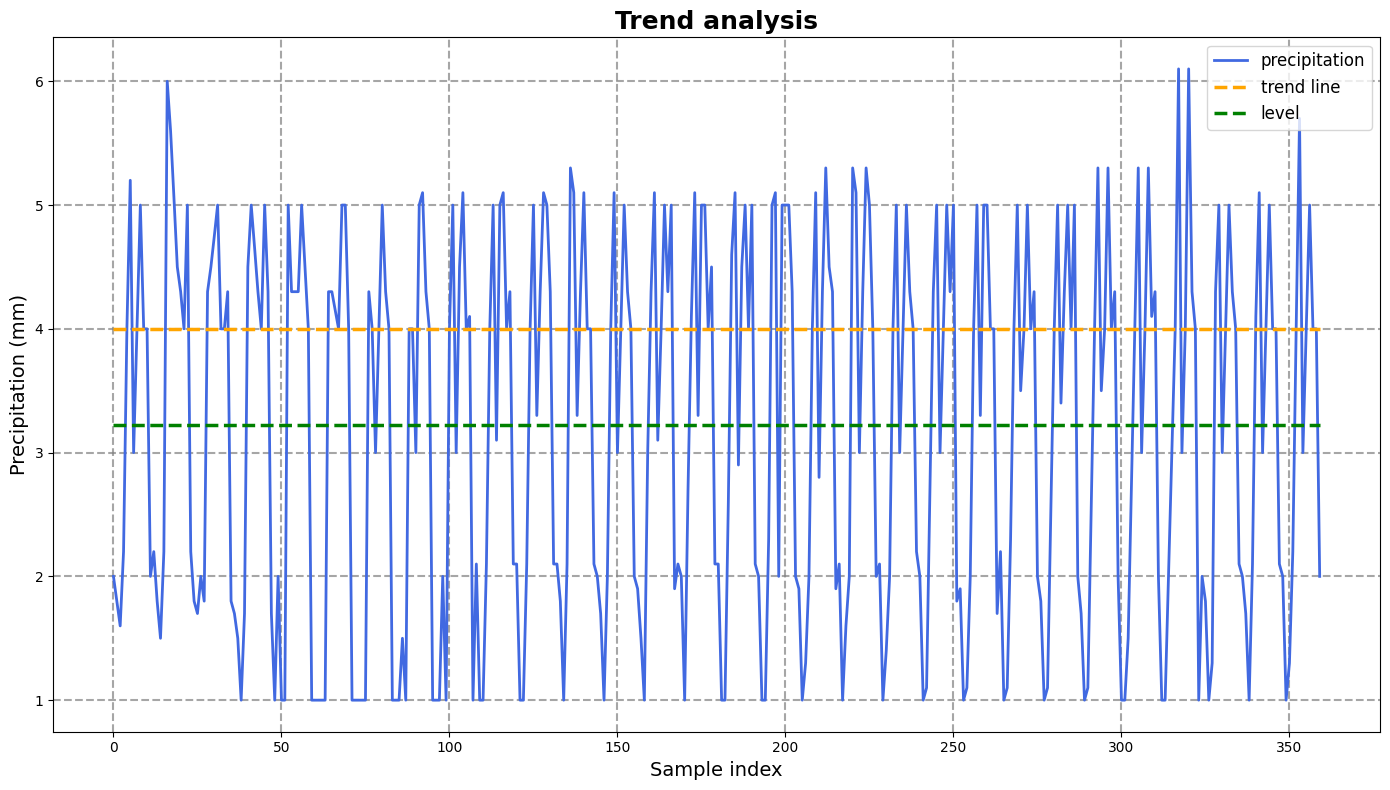

Trend                   no trend
p-value                 0.872859
Slope                        0.0
Intercept                    4.0
Test Statistic             364.0
Variance S        5145443.333333
Alpha                       0.01
dtype: object

In [46]:
def analyze_trend(
        data_series: pd.Series, 
        alpha: float = 0.01
    ) -> pd.Series:
    """Analyze trend in time series data using Mann-Kendall test
    
    Performs Mann-Kendall trend test and visualizes the trend line and level
    
    Args:
        data_series: Time series data to analyze
        alpha: Significance level for the test (default: 0.01)
    
    Returns:
        Results containing trend information including direction, p-value,
        slope, intercept, test statistic, variance, and significance level
    
    Example:
        >>> trend_results = analyze_trend(df['precipitation'])
    """
    mk_result = mk.original_test(data_series, alpha=alpha)

    trend_results = pd.Series({
        'Trend': mk_result.trend,
        'p-value': mk_result.p,
        'Slope': mk_result.slope,
        'Intercept': mk_result.intercept,
        'Test Statistic': getattr(mk_result, 's', 'N/A'),
        'Variance S': getattr(mk_result, 'var_s', 'N/A'),
        'Alpha': alpha
    })

    # Mann-Kendall test result
    slope = mk_result.slope
    intercept = mk_result.intercept

    # Calculate the trend line
    trend_line = slope * np.arange(len(data_series)) + intercept
    level = np.full(len(data_series), data_series.mean())
    
    # Plotting
    plt.plot(np.arange(len(data_series)), data_series, label='precipitation', color='royalblue')
    plt.plot(np.arange(len(data_series)), trend_line, label='trend line', color='orange', linestyle='--', lw=2.5)
    plt.plot(np.arange(len(data_series)), level, label='level', color='green', linestyle='--', lw=2.5)

    plt.title('Trend analysis', fontsize=18)
    plt.xlabel('Sample index', fontsize=14)
    plt.ylabel('Precipitation (mm)', fontsize=14)
    plt.grid(color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
    plt.legend(loc='upper right', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    return trend_results

analyze_trend(df['precipitation'])



### Seasonality


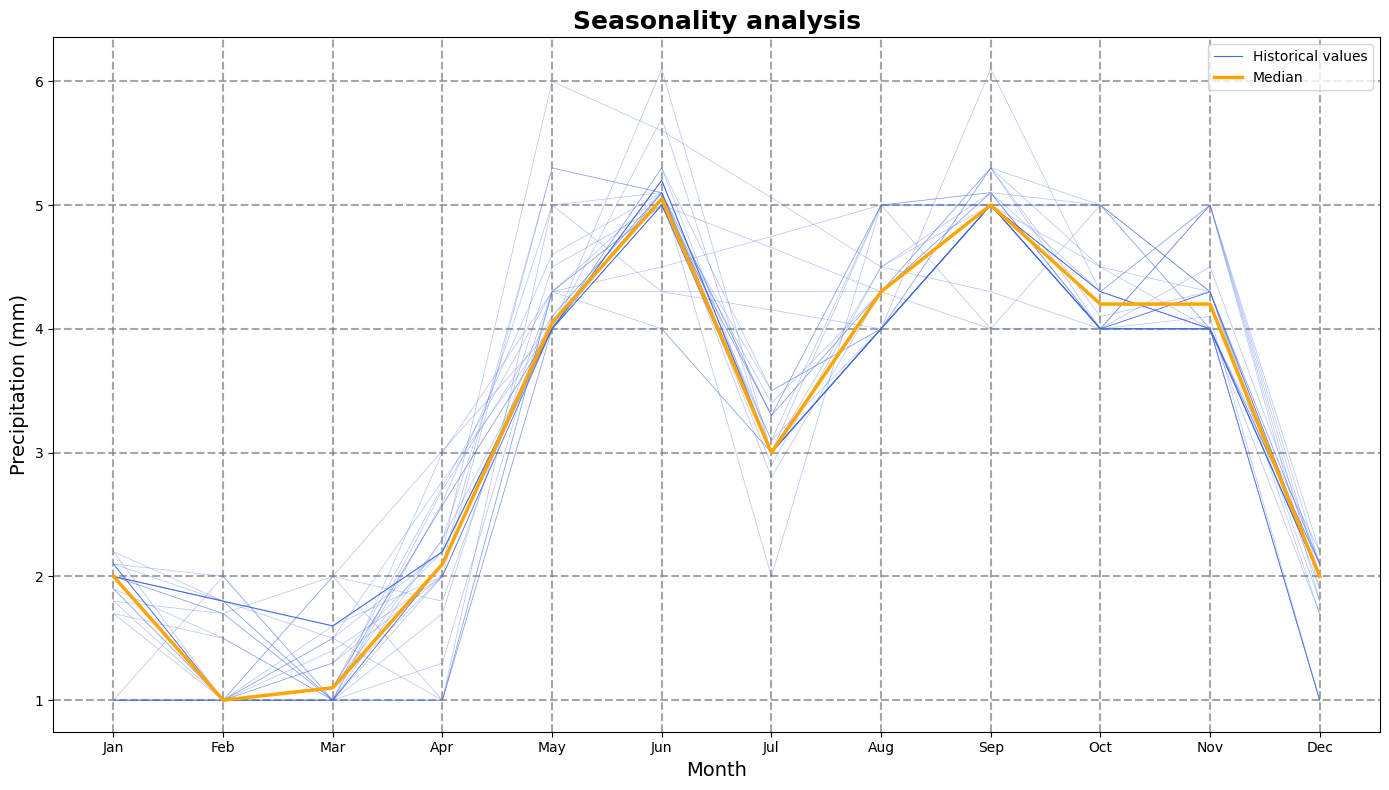

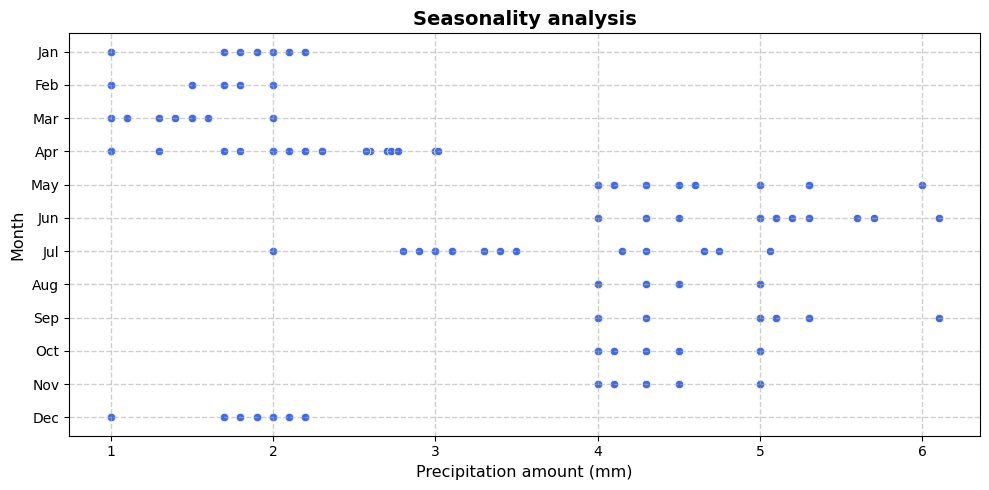

In [47]:
def analyze_seasonality(
        df: pd.DataFrame
    ) -> None:
    """Analyze seasonal patterns in time series data
    
    Creates two visualizations: 
    1. Time series plot showing historical values and monthly median
    2. Scatter plot showing precipitation distribution by month
    
    Args:
        df: DataFrame containing time series data with columns:
            - 'month': Month number
            - 'month_name': Month name
            - 'year': Year
            - 'precipitation': Precipitation values
    
    Example:
        >>> analyze_seasonality(df)
    """
    # Calculate the average monthly Precipitation value
    monthly_median = df.groupby('month')['precipitation'].median()
    years = df['year'].unique()
    month_name = df['month_name'].unique()

    # First year
    first_year = df[df['year'] == years[0]]['precipitation'].values
    
    # Plot time series
    plt.plot(month_name, first_year, '-', color='royalblue', linewidth=0.8, label='Historical values')

    # Following years (1992 onwards)
    for year in years[1:]:
        year_data = df[df['year'] == year]['precipitation'].values
        plt.plot(month_name, year_data, '-', color='royalblue', linewidth=0.5, alpha=0.4)

    plt.plot(month_name, monthly_median, color='orange', linewidth=2.5, label='Median')

    plt.title('Seasonality analysis', fontsize=18)
    plt.xlabel('Month', fontsize=14)
    plt.ylabel('Precipitation (mm)', fontsize=14)
    plt.grid(color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
    plt.tight_layout()
    plt.legend()
    plt.show()
    
    # Plot scatter
    plt.figure(figsize=(10,5))
    sns.scatterplot(data=df, x='precipitation', y='month_name', color='royalblue')
    plt.title('Seasonality analysis', fontsize=14)
    plt.xlabel('Precipitation amount (mm)').set_fontsize(11.5)
    plt.ylabel('Month').set_fontsize(11.5)
    plt.tight_layout()
    plt.grid(linewidth=1, alpha=0.6)
    plt.show()

analyze_seasonality(df)



### Stationarity 


In [48]:
def adf_test(
        timeseries: pd.Series
    ) -> pd.Series:
    """Perform Augmented Dickey-Fuller test for stationarity
    
    Tests the null hypothesis that a unit root is present in time series
    
    Args:
        timeseries: Time series data to test for stationarity
    
    Returns:
        Test results containing test statistic, p-value, lags number,
        and number of observations used
    
    Example:
        >>> adf_results = adf_test(df['precipitation'])
    """
    print('Results of the Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            'Test Statistic',
            'p-value',
            'Lags Number',
            'Number of Observation Used'
        ]
    )
    
    # Interpretation
    if dftest[1] < 0.01:
        print("We reject the null hypothesis: the series is stationary.")
    else:
        print("The null hypothesis is not rejected: the series has a unit root and is non-stationary.")
        
    return dfoutput

adf_test(df['precipitation'])


Results of the Dickey-Fuller Test:
The null hypothesis is not rejected: the series has a unit root and is non-stationary.


Test Statistic                 -2.368781
p-value                         0.150742
Lags Number                    11.000000
Number of Observation Used    348.000000
dtype: float64


### Periodicity


In [49]:

def check_periodicity(
        df: pd.DataFrame
    ) -> pd.DataFrame:
    """Check if time series data has consistent monthly intervals
    
    Verifies that all samples are taken at regular 1-month intervals
    
    Args:
        df: DataFrame with datetime index to check for periodicity
    
    Returns:
        DataFrame containing any inconsistencies found, with columns:
            - Next_month_time: Expected next month timestamp
            - Difference: Actual time difference between consecutive samples
    
    Example:
        >>> inconsistencies = check_periodicity(df)
    """
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)  

    # Calculate the expected date for the next month
    df['Next_month_time'] = df.index + pd.offsets.MonthBegin(1)

    # Calculate the difference excluding the last sample
    df['Difference'] = df['Next_month_time'].shift(1) - df.index

    # Filter non-null differences (excluding the first value which is NaN due to the shift)
    inconsistencies = df[df['Difference'] != pd.Timedelta(0)].dropna(subset=['Difference'])

    if inconsistencies.empty:
        print("All precipitation samples have been taken at 1-month intervals.")
    else:
        print("There are inconsistent time intervals in the precipitation samples.")
        print("Inconsistencies found:")
        print(inconsistencies[['Next_month_time', 'Difference']])
    
    return inconsistencies

check_periodicity(df)


All precipitation samples have been taken at 1-month intervals.


,year,month_name,precipitation,month,Next_month_time,Difference
date,,,,,,



### Homogeneity


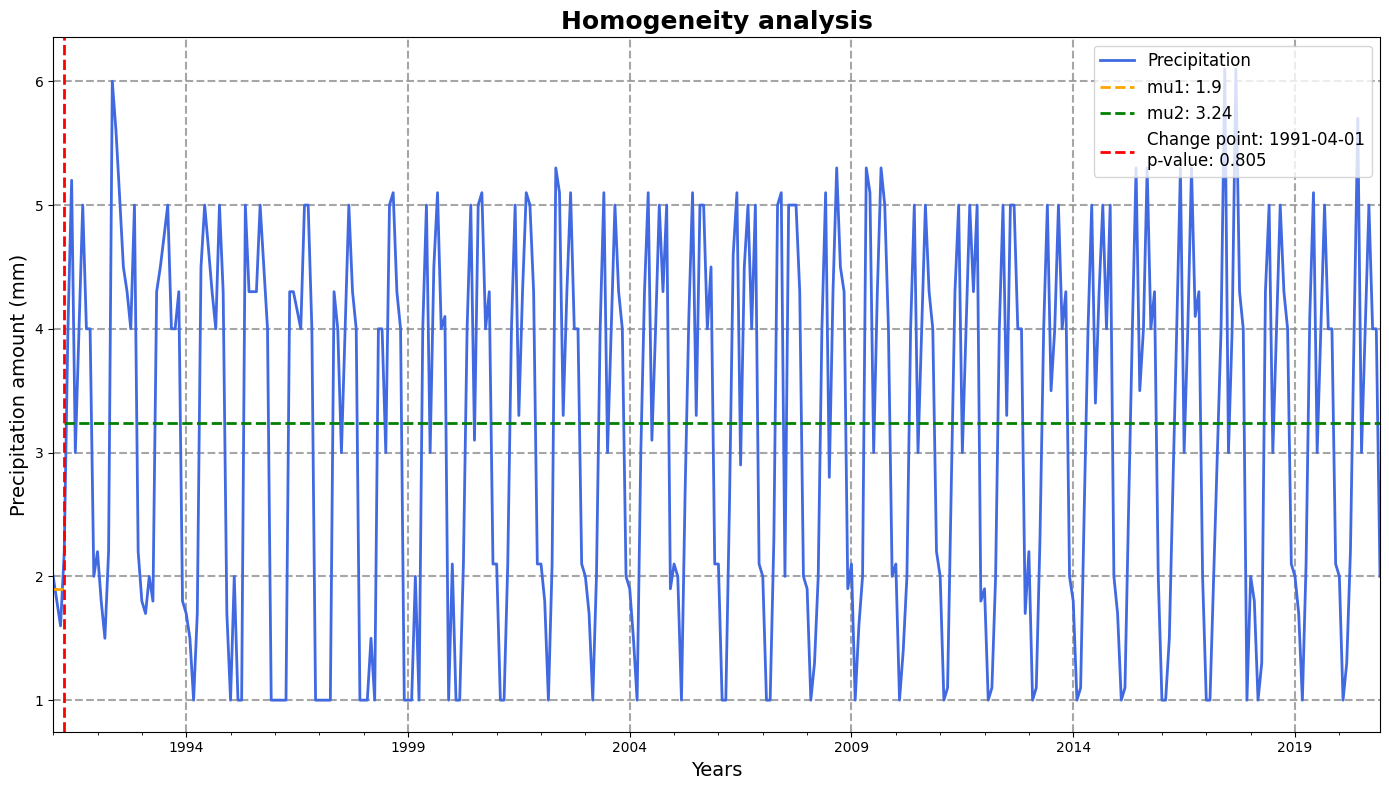

Change Point               1991-04-01
p-value                         0.805
Is Homogeneous                   True
Mean Before Change (μ1)           1.9
Mean After Change (μ2)        3.23532
Test Statistic               3.170064
Critical Value                    N/A
dtype: object

In [50]:

def analyze_homogeneity(
        data_series: pd.Series
    ) -> pd.Series:
    """Analyze time series homogeneity using SNHT (Standard Normal Homogeneity Test)
    
    Detects change points and tests for homogeneity in the time series
    
    Args:
        data_series: Time series data to test for homogeneity
    
    Returns:
        Test results containing change point, p-value, homogeneity status,
        means before/after change, test statistic, and critical value
    
    Example:
        >>> homogeneity_results = analyze_homogeneity(df['precipitation'])
    """
    result_snht = hg.snht_test(data_series)

    # Get test statistics
    loc = result_snht.cp         # Change point date (eg: '1991-04-01')
    mu1 = result_snht.avg.mu1    # Average before the change
    mu2 = result_snht.avg.mu2    # Average after the change
    
    # Plot the precipitation series
    data_series.plot(label='Precipitation', color='royalblue')

    # Horizontal lines (using dates)
    plt.hlines(mu1, 
               xmin=data_series.index.min(),  
               xmax=pd.to_datetime(loc),       
               linestyles='--', lw=2, colors='orange', 
               label=f'mu1: {round(mu1, 2)}')

    plt.hlines(mu2, 
               xmin=pd.to_datetime(loc),       
               xmax=data_series.index.max(),  
               linestyles='--', colors='g', lw=2, 
               label=f'mu2: {round(mu2, 2)}')

    # Vertical line of the change point 
    plt.axvline(x=pd.to_datetime(loc), 
                linestyle='--', color='red', lw=2,
                label=f'Change point: {loc}\np-value: {result_snht.p}')

    plt.title('Homogeneity analysis', fontsize=18)
    plt.xlabel('Years')
    plt.ylabel('Precipitation amount (mm)')
    plt.legend(loc='upper right', fontsize=12)
    plt.grid(color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
    plt.tight_layout()
    plt.show()

    result_snht= pd.Series({
        'Change Point': result_snht.cp,
        'p-value': result_snht.p,
        'Is Homogeneous': not result_snht.h,
        'Mean Before Change (μ1)': result_snht.avg.mu1,
        'Mean After Change (μ2)': result_snht.avg.mu2,
        'Test Statistic': getattr(result_snht, 'T', 'N/A'),
        'Critical Value': getattr(result_snht, 'critical_value', 'N/A')
    }) 
    
    return result_snht

analyze_homogeneity(df['precipitation'])



### Non-linearity


In [51]:
def bds_test(
        timeseries: pd.Series, 
        alpha: float
    ) -> pd.Series:
    """Perform BDS test for non-linearity in time series
    
    Tests the null hypothesis that data is independently and identically distributed
    
    Args:
        timeseries: Time series data to test for non-linearity
        alpha: Significance level for the test
    
    Returns:
        Test results containing test statistic, p-value, significance level,
        and non-linearity indication
    
    Example:
        >>> bds_results = bds_test(df['precipitation'], 0.01)
    """
    print('Results of the BDS Test:')
    dftest = bds(timeseries)

    bds_results = pd.Series({
        'Test Statistic': dftest[0],
        'p-value': dftest[1],
        'Significance Level (α)': alpha,
        'Is Non-linear': dftest[1] < alpha
    })

    if dftest[1] < alpha:               #compare p-value with significance level 
        print('The series is non-linear')
    else:
        print('The series appears to be linear') 
    return bds_results

bds_test(df['precipitation'], 0.01) #set a significance level of 0.01


Results of the BDS Test:
The series is non-linear


Test Statistic                29.095726815260896
p-value                   4.065787252981372e-186
Significance Level (α)                      0.01
Is Non-linear                               True
dtype: object

### Series complexity: autocorrelation


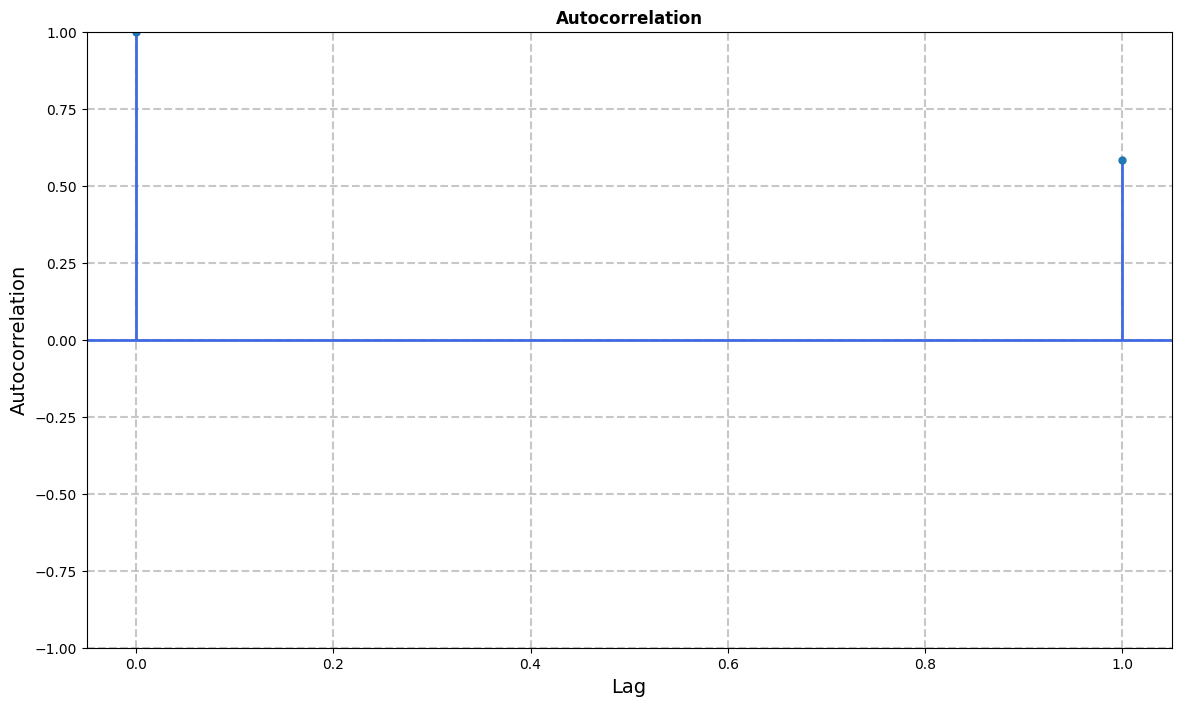

In [52]:
def analyze_autocorrelation(
        data_series: pd.Series, 
        alpha: float = 0.01, 
        lags: int = 1
    ) -> None:
    """Analyze autocorrelation in time series data
    
    Plots autocorrelation function (ACF) to identify patterns and dependencies
    
    Args:
        data_series: Time series data to analyze
        alpha: Significance level for confidence intervals (default: 0.01)
        lags: Number of lags to include in the plot (default: 1)
    
    Example:
        >>> analyze_autocorrelation(df['precipitation'])
    """
    plot_acf(data_series, alpha=alpha, lags=lags)
    plt.title('Autocorrelation')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.grid(linewidth=1.5, alpha=0.7)
    plt.show()

analyze_autocorrelation (df['precipitation'])